# **STASTISTICKÝ PROJEKT**

# Úvod

V rámci tohoto statistického projektu bych se chtěl dozvědět, zdali má domácí prostředí statistický vliv na výsledek fotbalového zápasu (jestli domácí týmy vyhrávají častěji než hostující týmy), a jestli se podíl výher domácích týmů změnil v posledních letech.

Tyto informace budu zkoumat na datech z první španělské fotbalové ligy (La Ligy) od sezóny 1995-1996 až do sezóny 2023-2024. 

Dataset je dostupný na stránce Kaggle: https://www.kaggle.com/datasets/kishan305/la-liga-results-19952020



In [101]:
# import důležitých knihoven
import pandas as pd
from scipy.stats import chisquare, ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
# načtení a příprava dat
data = pd.read_csv("LaLiga_Matches.csv")

# v datech vytvoříme novou položku - rok odehraní zápasu, s čímž se nám bude později lépe pracovat
data["Year"] = data["Date"].apply(lambda x: int(x.split('-')[2]))

data.head(-1)

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Year
0,1995-96,02-09-1995,La Coruna,Valencia,3,0,H,2.0,0.0,H,1995
1,1995-96,02-09-1995,Sp Gijon,Albacete,3,0,H,3.0,0.0,H,1995
2,1995-96,03-09-1995,Ath Bilbao,Santander,4,0,H,2.0,0.0,H,1995
3,1995-96,03-09-1995,Ath Madrid,Sociedad,4,1,H,1.0,1.0,D,1995
4,1995-96,03-09-1995,Celta,Compostela,0,1,A,0.0,0.0,D,1995
...,...,...,...,...,...,...,...,...,...,...,...
10877,2023-24,30-09-2023,Sociedad,Ath Bilbao,3,0,H,1.0,0.0,H,2023
10878,2023-24,01-10-2023,Almeria,Granada,3,3,D,3.0,0.0,H,2023
10879,2023-24,01-10-2023,Alaves,Osasuna,0,2,A,0.0,1.0,A,2023
10880,2023-24,01-10-2023,Ath Madrid,Cadiz,3,2,H,1.0,2.0,A,2023


# Část 1: Vítězí domácí týmy častěji než hostující?

V této části se budu věnovat tomu, zda existuje tzv. **domácí výhoda** - čili jestli týmy, které hrají na domácí půdě vyhrávají častěji než hosté. Remízy do této statistiky nebudu brát v potaz. Chci zjistit, zda je počet domácích vítězství statisticky významně vyšší než počet vítězství hostů.

K analýze použiji chí-kvadrát test dobré schody.

Hypotézy:

- **Nulová hypotéza (H₀):** Za předpokladu, že fotbalový zápas neskončí remízou, je šance na výhru domácího týmu stejná jako šance na výhru hostujícího týmu.

- **Alternativní hypotéza (H₁):** Šance na výhru domácího a hostujícího týmu není stejná.

Nejprve z dat odfiltrujeme remízy a následně si nová data vizualizujeme, abychom měli přehled, s čím pracujeme.

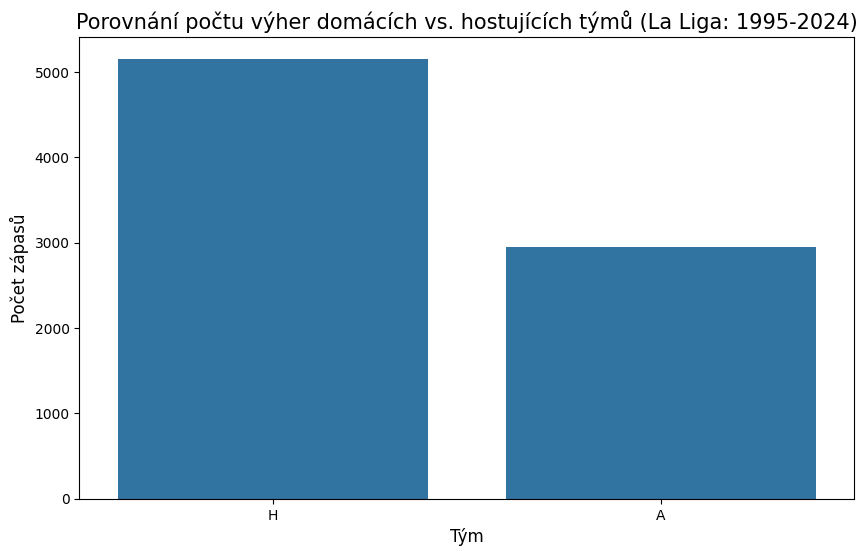

In [103]:
# z dat odstraníme remízy
data_without_draws = data[data["FTR"] != "D"]

# získáme počet výher domácích/hostů
win_counts = data_without_draws["FTR"].value_counts()

# sestrojíme graf
plt.figure(figsize=(10, 6))
sns.barplot(x=win_counts.index, y=win_counts.values)
plt.title("Porovnání počtu výher domácích vs. hostujících týmů (La Liga: 1995-2024)", fontsize=15)
plt.xlabel("Tým", fontsize=12)
plt.ylabel("Počet zápasů", fontsize=12)
plt.show()

Už od pohledu je jasně vidět, že rozdíl je znatelný.

Nyní provedeme statistický test, abychom potvrdili, že tento rozdíl není náhodný.

In [104]:
# spočítáme odhadované a opravdové poměry domácích/hostů
number_of_wins = win_counts["H"] + win_counts["A"]
expected = [number_of_wins / 2, number_of_wins / 2]
observed = [win_counts["H"], win_counts["A"]]

# provedeme test dobré shody
chi2, p_value = chisquare(observed, expected)

print(f"chí-kvadrát statistika: {chi2:.3f}")
print(f"p-hodnota: {p_value:.3e}")

chí-kvadrát statistika: 600.646
p-hodnota: 1.211e-132


Ze statistického testu nám vyšla extrémně nízká p-hodnota (hluboko pod hladinou významnosti 0.05). Proto můžeme nulovou hypotézu bezpečně zamítnout.

Vliv domácího prostředí je dle statistik značný a to potvrzuje domácí výhodu (minimálně v 1. španělské fotbalové lize).

Pojďme nyní na druhou část našeho statistického projektu.

# Část 2: Změnil se podíl výher domácích týmů v čase?

Ve druhé části se zabývám tím, jestli se výhoda domácího prostředí v průběhu let změnila. Fotbal se každým rokem vyvíjí, tudíž by se mohla zlepšit i příprava hostujících týmů.

Rozdělíme si data na dvě období a porovnáme průměrný podíl domácích výher pomocí dvouvýběrového t-testu. Jako hranici si zvolíme sezónu 2010-2011, nachází se přesně v polovině měřeného časového okna.

Hypotézy:

- **Nulová hypotéza (H₀)**: Průměrný podíl výher domácích týmů v dřívějším období (1995-2010) je stejný jako v pozdějším období (2010-2024).

- **Alternativní hypotéza (H₁)**: Průměrný podíl výher domácích týmů v dřívějším a pozdějším období se liší.

Nejprve se podívejme na data vizuálně.

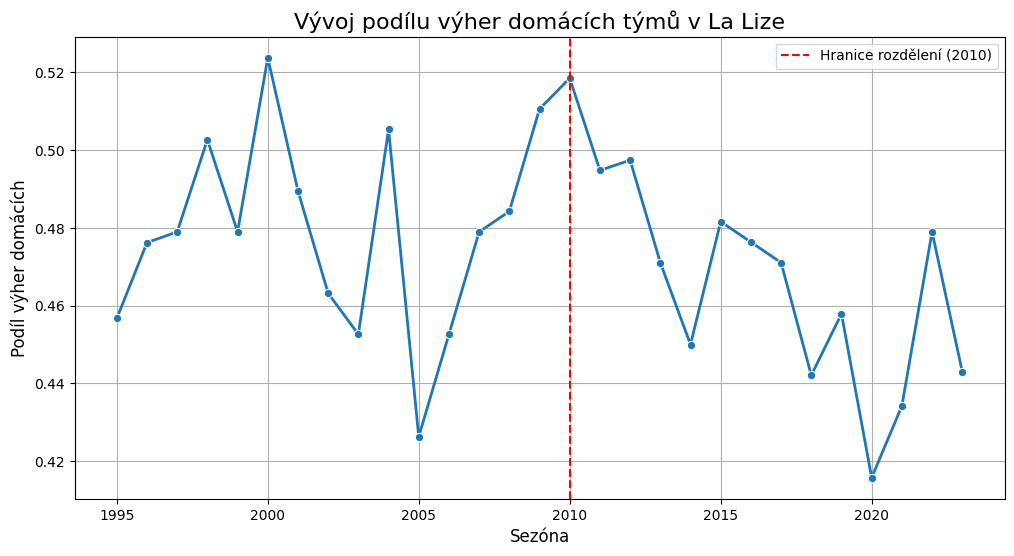

In [105]:
# výpočet podílu domácích výher pro každou sezónu
home_wins = (data.groupby("Season")["FTR"].apply(lambda x: (x == 'H').mean()).reset_index(name="HomeWinRate"))
home_wins['Year'] = home_wins['Season'].str.split('-').str[0].astype(int)

# vizualizujeme vývoj podílu domácích výher
plt.figure(figsize=(12, 6))
sns.lineplot(data=home_wins, x="Year", y="HomeWinRate", marker="o", linewidth=2)
# vizualizujme hranici rozdělení
plt.axvline(x=2010, color="red", linestyle="--", label="Hranice rozdělení (2010)")
plt.title("Vývoj podílu výher domácích týmů v La Lize", fontsize=16)
plt.xlabel("Sezóna", fontsize=12)
plt.ylabel("Podíl výher domácích", fontsize=12)
plt.grid(True)
plt.legend()
plt.show()


Z grafu je vidět mírná klesající tendence, zejména v posledních letech. Na první pohled ale nejde o nic statisticky průkazného.

Jelikož nemůžeme s jistotou říci, jestli mají data v obou obdobích stejné či rozdílné rozptyly, rozhodl jsem se pro Welchův t-test.

In [106]:
# rozdělení dat do dvou skupin
earlier_seasons = home_wins[home_wins["Year"] < 2010]["HomeWinRate"]
later_seasons = home_wins[home_wins["Year"] >= 2010]["HomeWinRate"]

# dvouvýběrový t-test
t_stat, p_value = ttest_ind(earlier_seasons, later_seasons, equal_var=False)

print(f"t-statistika: {t_stat:.3f}")
print(f"p-hodnota: {p_value:.3f}")

t-statistika: 1.210
p-hodnota: 0.237


Na základě dat nemůžeme s jistototu říci, že by se podíl výher domácích týmů mezi obdobími 1995-2010 a 2010-2024 nějak statisticky významně změnil. Nemůžeme tak zamítnout nulovou hypotézu (naše naměřenná p-hodnota je nad hladinou významnosti 0.05), což naznačuje, že se domácí výhoda v průběhu času nezvýšila ani nesnížila.

# Závěr

Můžeme s jistotou říci, že domácí výhoda v nejvyšší španělské fotbalové lize existuje. Na druhou stranu jsme zjistili, že v průbehu let se nijak zvlášť nezměnila.